
<font size = "5"> **Chapter 4: [Spectroscopy](CH4-Spectroscopy.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

#  Loading and Plotting an EELS Spectrum

part of 

<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes



## Content
Learn to open, plot and store an EELS spectrum.

Important parameters (meta-data) are stored in different parts of the meta-data, so that a quantitative analysis is possible. 

First we import the relevant packages. Please note that the EELS_tools package from pyTEMlib is essential.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

# import pyTEMlib packages
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.EELS_tools  as eelst 

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
windows
pyTEM version:  0.12.2019.3


# Load an EELS Spectrum:

Please see this [notebook](CH1-pyUSID.ipynb) to see how the pyUSID file system works

<IPython.core.display.Javascript object>


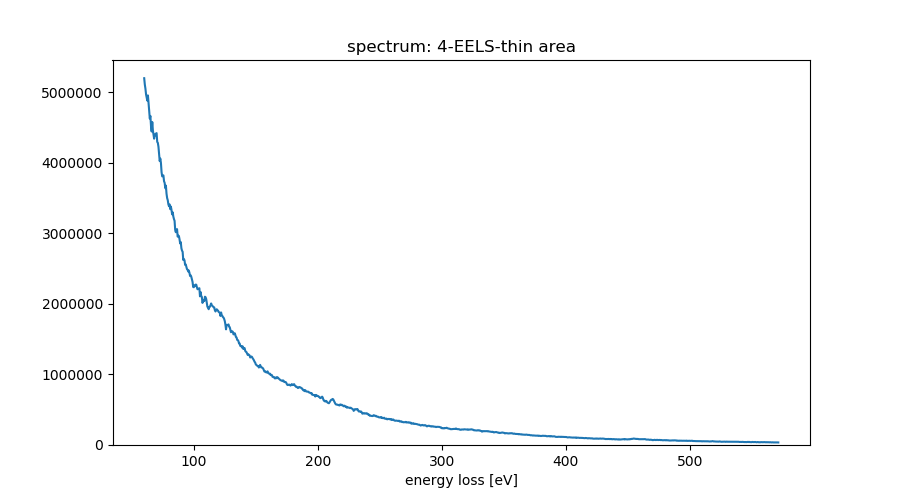

In [2]:
# Load file
h5_file = ft.h5open_file()
current_channel = h5_file['Measurement_000/Channel_000']

# get dictionary from current channel in pyUSID file
tags = ft.h5_get_dictionary(current_channel)


# plot according to what data type is in your file
if tags['data_type'] == 'EELS_spectrum':
    ## Start plotting
    plt.figure(figsize(9,5))
    
    plt.plot(tags['energy_scale'],tags['data']);
    plt.title('spectrum: '+ tags['title'])
    plt.xlabel('energy loss [eV]')
    plt.ylim(0);
else:
    print('Find an EELS spectrum to load, please!')



## Make Energy Scale andPlot

The energy scale above is linear and so a linear increasing numpy array (of size *spec_sizeX*)  is multiplied with the channel width (*spec_scaleX*), the first channel is in the variable *spec_offsetX*.

Energy Scale
Dispersion [eV/pixel] : 0.50 eV 
Offset [eV] : 370.00 eV 
Maximum energy [eV] : 1393.50 eV 


<IPython.core.display.Javascript object>


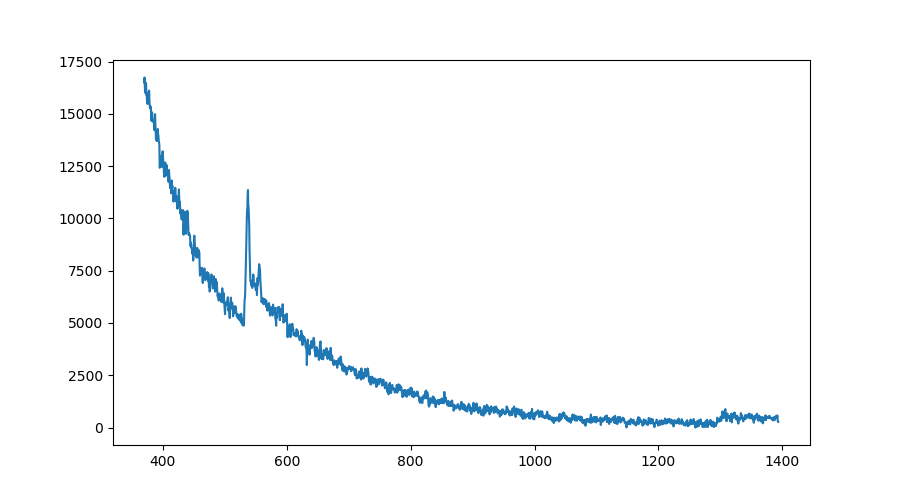

In [3]:
spectrum_tags = {}

## spectrall data
spectrum_tags['spectral_scale_x'] = current_channel['spectral_scale_x'][()]
spectrum_tags['spectral_units_x'] = current_channel['spectral_units_x'][()]
spectrum_tags['spectral_origin_x'] = current_channel['spectral_origin_x'][()]
spectrum_tags['spectral_size_x'] = float(current_channel['spectral_size_x'][()])

data = current_channel['Raw_Data'][0,:]
energy_scale = np.arange(spectrum_tags['spectral_size_x'])*spectrum_tags['spectral_scale_x']+spectrum_tags['spectral_origin_x']
    
spectrum_tags['energy_scale'] = energy_scale
spectrum = spectrum_tags['spectrum'] = data
print('Energy Scale')
print(f"Dispersion [eV/pixel] : {spectrum_tags['spectral_scale_x']:.2f} eV ")
print(f"Offset [eV] : {spectrum_tags['spectral_origin_x']:.2f} eV ")
print(f"Maximum energy [eV] : {spectrum_tags['energy_scale'][-1]:.2f} eV ")


plt.figure()
plt.plot(energy_scale, spectrum);
#plt.xlim(-5,60);

Let's compare the keys in the current_channel and  in the dictionary 

## Important Parameters in an EELS spectrum

In [3]:
for key in tags:
    if key in  ['data', 'energy_scale'] :
        print( key, ' -- with length: ', tags[key].shape)
    else:
        print(key, ': ',tags[key])

aberrations :  {}
acceleration_voltage :  100000.0
camera_length :  2.8
collection_angle :  33.0
convergence_angle :  30.0
exposure_spectrum :  5.0
image_type :  Image
integration_time :  55.0
machine_id :  utc
number_of_frames :  11
platform :  Windows-10-10.0.18362-SP0
pyUSID_version :  0.0.6.2
time_last_modified :  1569872975.8727393
timestamp :  2019_11_27-14_02_35
title :  4-EELS-thin area
data_type :  EELS_spectrum
data  -- with length:  (1024,)
spectral_scale_x :  0.5
spectral_units_x :  eV
spectral_origin_x :  60.0
spectral_size_x :  1024.0
energy_scale  -- with length:  (1024,)


the additional information in the dictionary comes from the attributes of the h5 group *current_channel*

In [5]:
additional_tags = dict(current_channel.attrs)

In [6]:
print(additional_tags.keys())

dict_keys(['exposure_spectrum', 'number_of_frames', 'collection_angle', 'convergence_angle', 'acceleration_voltage', 'image_type', 'camera_length', 'integration_time', 'time_last_modified'])


## Define All Important Experimental Parameter

In [7]:
#######################################
## Important Experimental Parameters ##
#######################################

spectrum_tags['eels_parameter'] = {}
spectrum_tags['eels_parameter']['integration_time_s'] = additional_tags['integration_time']
spectrum_tags['eels_parameter']['number_of_frames'] = additional_tags['number_of_frames']
spectrum_tags['eels_parameter']['acceleration_voltage_V'] = additional_tags['acceleration_voltage']
spectrum_tags['eels_parameter']['collectionAngle_mrad'] =50.
spectrum_tags['eels_parameter']['convergenceAngle_mrad'] =30.
spectrum_tags['eels_parameter']['integration_time'] = additional_tags['integration_time']

eels_p = spectrum_tags['eels_parameter']
print(f"intergation time: {eels_p['integration_time']:.2f} s summed over {eels_p['number_of_frames']:.2f} spectra ")

print(f"acceleration_voltage: {eels_p['acceleration_voltage_V']/1000.:.1f} keV ")
print(f"convergence semi-angle : {eels_p['convergenceAngle_mrad']:.1f} mrad ")
print(f"collection semi-angle : {eels_p['collectionAngle_mrad']:.1f} mrad ")


intergation time: 5.00 s summed over 1.00 spectra 
acceleration_voltage: 200.0 keV 
convergence semi-angle : 30.0 mrad 
collection semi-angle : 50.0 mrad 


## Normalizing Intensity Scale
The following normalization makes only sense if this is a low loss spectrum, <br> where the total number of counts represents approximatively the incident current **$I_0$**

<IPython.core.display.Javascript object>


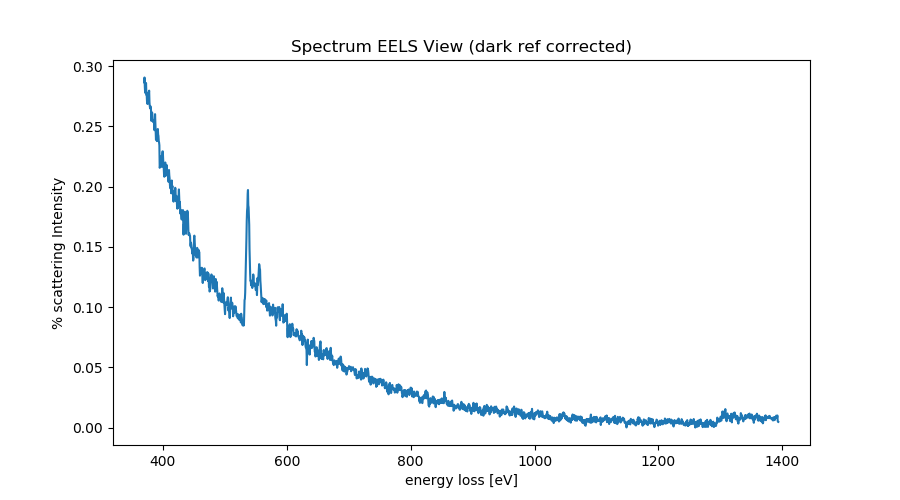

In [8]:
I_0 = sumSpec = sum(tags['data'])
plt.figure()
plt.plot(tags['energy_scale'],tags['data']/sumSpec*1e2)
plt.title ('Spectrum '+tags['title']);
plt.xlabel('energy loss [eV]')
plt.ylabel('% scattering Intensity');
#plt.xlim(-10,50)
#plt.ylim(0,8);


Close the **h5_file** to make it available for aother notebooks

In [9]:
h5_file.close()

## Navigation

### Back: [Spectroscopy](Ch4-Spectroscopy.ipynb)
### Next:  [Fit Zero-Loss](CH4-FitZeroLoss.ipynb)

### Chapter 4: [Spectroscopy](CH4-Spectroscopy.ipynb)
### Index: [Index](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)